# Jonathan Halverson
# Friday, December 29, 2017
# Reusing pretrained layers of an autoencoder

Here we pretend we only have limited labeled data. We will only use 10% of the MNIST labels. First we will train a denoising autoencoder on the whole train set then reuse the lower layers and train a new DNN on a fraction of the labeled data. Can we achieve the same accuracy as using the full supervised training set?

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_valid = mnist.validation.images
y_valid = mnist.validation.labels
X_test = mnist.test.images
y_test = mnist.test.labels
d = 28

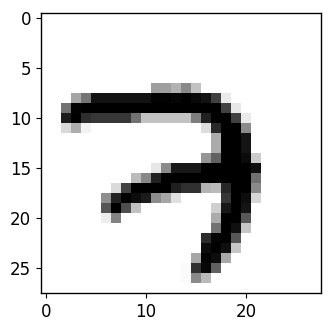

In [4]:
plt.imshow(X_train[0].reshape(d, d), cmap='binary')

Here are the counts of the digits (approximately balanced):

<Container object of 10 artists>

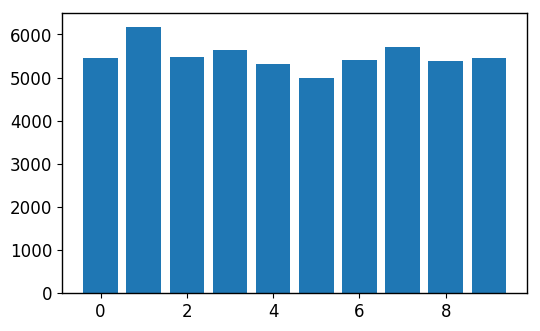

In [5]:
plt.bar(np.arange(10), np.bincount(y_train))

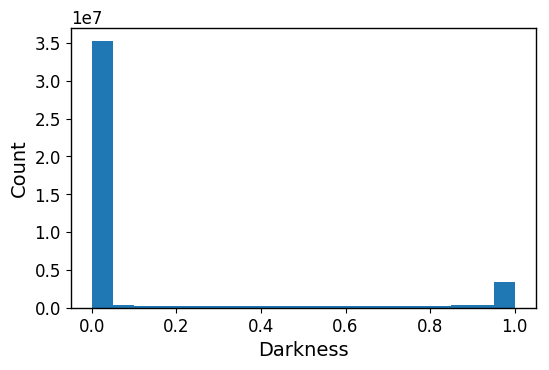

In [6]:
plt.hist(X_train.flatten(), bins=20)
plt.xlabel('Darkness')
plt.ylabel('Count')

We see the pixels are mostly colored white (zero) and black (one).

### Step 0: Create a restricted training set using 10% of the original training set

Make the training set for the supervised phase:

In [7]:
N = y_train.size
ind = np.random.choice(np.arange(N), size=N//10, replace=False)
X_10, y_10 = X_train[ind], y_train[ind]

In [8]:
def fetch_batch(A, b, batch_size):
     # could use randint and bootstrapping
     indices = np.random.choice(range(A.shape[0]), size=batch_size, replace=False)
     return A[indices], b[indices]

### Step 1: Create a stacked, undercomplete and denoising autoencoder

In [9]:
tf.reset_default_graph()

In [10]:
n_inputs = d * d
n_hidden_1 = 22 * 22
n_hidden_2 = 14 * 14
n_hidden_3 = n_hidden_1
n_outputs = n_inputs
keep_prob = 0.5

In [11]:
training = tf.placeholder_with_default(False, shape=(None), name='training')

X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name='inputs')
X_dropout = tf.layers.dropout(X, keep_prob, training=training)

he_init = tf.contrib.layers.variance_scaling_initializer()
from functools import partial
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu, kernel_initializer=he_init)

hidden1 = my_dense_layer(X_dropout, n_hidden_1, name='hidden1')
hidden2 = my_dense_layer(hidden1, n_hidden_2, name='hidden2')
hidden3 = my_dense_layer(hidden2, n_hidden_3, name='hidden3')
outputs = my_dense_layer(hidden3, n_outputs, activation=None, name='outputs')

In [12]:
reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(reconstruction_loss)

In [13]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [14]:
batch_size = 200
epochs = 50
codings = hidden2

In [15]:
ckpt_path = '/tmp/data/autoen_to_limited_supervised.ckpt'
with tf.Session() as sess:
     init.run()
     print '-', reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, _ = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch, training:False}) # DROPOUT IS TURNED OFF DURING TRAINING
          if not (epoch % 5): print epoch, reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     save_path = saver.save(sess, ckpt_path)

- 0.294454
0 0.0215538
5 0.0149877
10 0.0132624
15 0.0122238
20 0.0114927
25 0.0110008
30 0.010657
35 0.0103352
40 0.0101054
45 0.00992177
50 0.00969913


INFO:tensorflow:Restoring parameters from /tmp/data/autoen_to_limited_supervised.ckpt


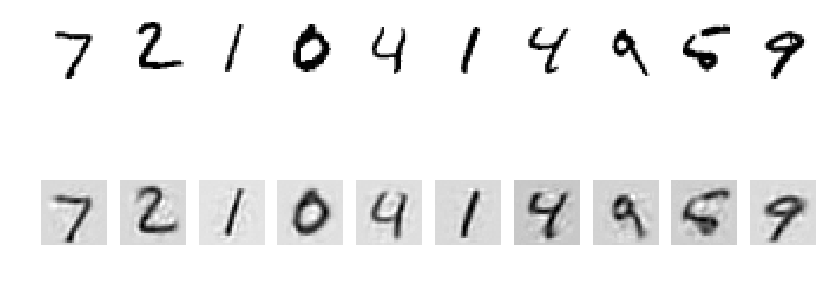

In [16]:
with tf.Session() as sess:
     saver.restore(sess, ckpt_path)
     outputs_test = outputs.eval(feed_dict={X:X_test})
     plt.subplots(figsize=(10, 4))
     for i in range(10):
          plt.subplot(2, 10, i + 1)
          plt.imshow(X_test[i].reshape(d, d), cmap='binary'); plt.axis('off')
          plt.subplot(2, 10, i + 11)
          plt.imshow(outputs_test[i].reshape(d, d), cmap='binary'); plt.axis('off')

We see that the reconstruction loss is quite small and the outputs very much look like the inputs.

### Step 2: Construct a DNN by reusing hidden layers 1 and 2

In [17]:
tf.reset_default_graph()

In [18]:
saver = tf.train.import_meta_graph(ckpt_path + '.meta') # restores the graph, but not the values

In [19]:
[v.name for v in tf.trainable_variables()]

[u'hidden1/kernel:0',
 u'hidden1/bias:0',
 u'hidden2/kernel:0',
 u'hidden2/bias:0',
 u'hidden3/kernel:0',
 u'hidden3/bias:0',
 u'outputs/kernel:0',
 u'outputs/bias:0']

In [20]:
for op in tf.get_default_graph().get_operations():
     if 'hidden3' in op.name: print (op.name)

hidden3/kernel/Initializer/truncated_normal/shape
hidden3/kernel/Initializer/truncated_normal/mean
hidden3/kernel/Initializer/truncated_normal/stddev
hidden3/kernel/Initializer/truncated_normal/TruncatedNormal
hidden3/kernel/Initializer/truncated_normal/mul
hidden3/kernel/Initializer/truncated_normal
hidden3/kernel
hidden3/kernel/Assign
hidden3/kernel/read
hidden3/bias/Initializer/Const
hidden3/bias
hidden3/bias/Assign
hidden3/bias/read
hidden3/MatMul
hidden3/BiasAdd
hidden3/Relu
gradients/hidden3/Relu_grad/ReluGrad
gradients/hidden3/BiasAdd_grad/BiasAddGrad
gradients/hidden3/BiasAdd_grad/tuple/group_deps
gradients/hidden3/BiasAdd_grad/tuple/control_dependency
gradients/hidden3/BiasAdd_grad/tuple/control_dependency_1
gradients/hidden3/MatMul_grad/MatMul
gradients/hidden3/MatMul_grad/MatMul_1
gradients/hidden3/MatMul_grad/tuple/group_deps
gradients/hidden3/MatMul_grad/tuple/control_dependency
gradients/hidden3/MatMul_grad/tuple/control_dependency_1
hidden3/kernel/Adam/Initializer/Const


Let's freeze everything except for the output layer:

In [21]:
X = tf.get_default_graph().get_tensor_by_name("inputs:0")
y = tf.placeholder(dtype=tf.int32, shape=(None))

hidden2 = tf.get_default_graph().get_tensor_by_name("hidden2/Relu:0")
hidden3 = tf.layers.dense(hidden2, n_hidden_3, name="new_hidden3")
new_outputs = tf.layers.dense(hidden3, n_outputs, name="new_outputs")

In [22]:
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='new')
train_vars

[<tf.Variable 'new_hidden3/kernel:0' shape=(196, 484) dtype=float32_ref>,
 <tf.Variable 'new_hidden3/bias:0' shape=(484,) dtype=float32_ref>,
 <tf.Variable 'new_outputs/kernel:0' shape=(484, 784) dtype=float32_ref>,
 <tf.Variable 'new_outputs/bias:0' shape=(784,) dtype=float32_ref>]

In [23]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_outputs)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.005, name='Adam2')
training_op = optimizer.minimize(loss, var_list=train_vars)
correct = tf.nn.in_top_k(new_outputs, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [24]:
epochs = 50
batch_size = 200

In [25]:
with tf.Session() as sess:
     init.run()
     saver.restore(sess, ckpt_path) # restore the variable values
     wts_before = [v for v in tf.trainable_variables() if v.name == "hidden2/kernel:0"][0].eval()
     for epoch in xrange(epochs + 1):
          for iteration in xrange(y_10.size // batch_size):
               X_batch, y_batch = fetch_batch(X_10, y_10, batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
          if not (epoch % 5): print epoch, accuracy.eval(feed_dict={X:X_test, y:y_test}), loss.eval(feed_dict={X:X_test, y:y_test})
     wts_after = [v for v in tf.trainable_variables() if v.name == "hidden2/kernel:0"][0].eval()

INFO:tensorflow:Restoring parameters from /tmp/data/autoen_to_limited_supervised.ckpt
0 0.7532 0.774384
5 0.883 0.372242
10 0.8895 0.370333
15 0.8876 0.368632
20 0.885 0.377555
25 0.8836 0.398101
30 0.8893 0.38166
35 0.8826 0.413075
40 0.8824 0.398352
45 0.894 0.365686
50 0.8844 0.380994


In [26]:
np.allclose(wts_before, wts_after)

True

### Step 3: Try again without freezing the layers (and no dropout)

In [27]:
tf.reset_default_graph()

In [28]:
X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name='inputs')
y = tf.placeholder(dtype=tf.int32, shape=(None))

hidden1 = my_dense_layer(X, n_hidden_1, name='hidden1')
hidden2 = my_dense_layer(hidden1, n_hidden_2, name='hidden2')
hidden3 = my_dense_layer(hidden2, n_hidden_3, name='hidden3')
outputs = my_dense_layer(hidden3, n_outputs, activation=None, name='outputs')

In [29]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=outputs)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(outputs, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [30]:
init = tf.global_variables_initializer()

#### Here we use the full train set to train

In [31]:
batch_size = 200
epochs = 25

In [32]:
with tf.Session() as sess:
     init.run()
     print '-', accuracy.eval(feed_dict={X:X_test, y:y_test}), loss.eval(feed_dict={X:X_test, y:y_test})
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, y_batch = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
          if not (epoch % 5): print epoch, accuracy.eval(feed_dict={X:X_test, y:y_test}), loss.eval(feed_dict={X:X_test, y:y_test})

- 0.0001 6.55797
0 0.964 0.121262
5 0.98 0.0711673
10 0.968 0.149448
15 0.9802 0.0889154
20 0.9813 0.0906406
25 0.9844 0.0872181


#### Here we use one-tenth of the training set

In [33]:
batch_size = 200
epochs = 25

In [34]:
with tf.Session() as sess:
     init.run()
     print '-', accuracy.eval(feed_dict={X:X_test, y:y_test}), loss.eval(feed_dict={X:X_test, y:y_test})
     for epoch in xrange(epochs + 1):
          for iteration in xrange(y_10.size // batch_size):
               X_batch, y_batch = fetch_batch(X_10, y_10, batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
          if not (epoch % 5): print epoch, accuracy.eval(feed_dict={X:X_test, y:y_test}), loss.eval(feed_dict={X:X_test, y:y_test})

- 0.0 6.77211
0 0.8767 0.41148
5 0.9397 0.206468
10 0.9472 0.210446
15 0.953 0.201709
20 0.9544 0.213558
25 0.9538 0.2209


### Summary

The first step was to train an autoencoder using all of the train set. This unsupervised phase was done with the input having 784 neurons, hidden layer 1 with 484, hidden layer 2 with 144 and hidden layer 3 with 484. Of course, the number of output neurons is equal to the number of input neurons. Dropout was used on the input layer during training. We achieved a low value for the reconstruction loss and the output digits looked very much like the input digits.

In the next phase we reused the weights and biases from the first two hidden layers and retrained the third hidden layer and the output layer using only 10% of the supervised training data. This resulted in an accuracy of only 91%.

We then created a new network with the same number of layers and number of neurons per layer and trained the network from scratch using the entire training set and then one-tenth of the training set.


|Model notes| Accuracy|
|---|---|
|100% of training set (no autoencoder pre-training)|97.2%|
|10% of training set (no autoencoder pre-training)|95.5%|
|10% of training set with autoencoder pre-training on entire training set|95.5%|